# Análisis de los nombres elegidos por los estadounidenses (1910-2020)

## Carga de los datos

In [1]:
# librerias a utilizar
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# cliente bigquery para consultar database
client = bigquery.Client()

# Cargo la tabla de nombres que me interesa
dataset_ref = client.dataset('usa_names', project='bigquery-public-data')
table_ref = dataset_ref.table('usa_1910_current')
names_table = client.get_table(table_ref)
                               
# Cabecera de la tabla, para inspeccionar datos
client.list_rows(names_table, max_results=3).to_dataframe()

,state,gender,year,name,number
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10


In [2]:
# Evito superar cuota de lectura de BigQuery
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

## Cantidad total de nombres registrados en la historia. Variedad por género.

Desde que se tiene registro, en USA se utilzaron un total de 35236 nombres distintos
Los nombres femeninos representan un 60.1%, mientras que los masculinos, el restante 39.9%


Text(0, 0.5, 'Cantidad de nombres')

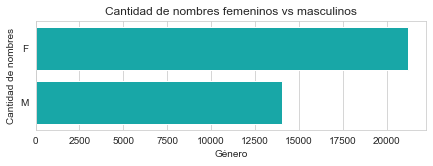

In [5]:
# total de nombres distintos
names_query = '''
SELECT name, gender, SUM(number) AS number
FROM `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY name, gender
'''

names_query_job = client.query(names_query, job_config=safe_config)
names = names_query_job.to_dataframe()

# Cantidad de Nombres Femeninos y Masculinos utilizados. 
# Porcentajes del Total. Analisis de variedad.
num_names = names.name.count()
f_num_names = names[names.gender == 'F'].name.count()
m_num_names = names[names.gender == 'M'].name.count()
f_names_perc = f_num_names/num_names * 100
m_names_perc = m_num_names/num_names * 100

print('Desde que se tiene registro, en USA se utilzaron un total de {} nombres distintos'.format(num_names))
print('Los nombres femeninos representan un {:.1f}%, mientras que los masculinos, el restante {:.1f}%'.format(f_names_perc, m_names_perc))

plt.figure(figsize=(7,2))
sns.set_style('whitegrid')

# sns.catplot(x="gender", kind="count", palette="ch:.25", data=unique_names)
sns.countplot(y="gender", data=names, color="c")

plt.title('Cantidad de nombres femeninos vs masculinos')
plt.xlabel('Género')
plt.ylabel('Cantidad de nombres')

### Primeras conclusiones
Del gráfico anterior, se puede observar que existe entre las mujeres, una mayor variedad de nombres, más precisamente un 50% más que entre los hombres (aproximadamente 21.000 nombres diferentes contra 14.000).

#### Observaciones
Tener en cuenta que en el análisis anterior se consideraron como "diferentes" los nombres teniendo en cuenta el género, por tanto, si el nombre "Quimey" ha sido registrado tanto femenino como masculino, se comete una redundancia, pero es la mejor manera de expresarlo, ya que sino las relaciones porcentuales de femenino y masculino resultarían en una incongruencia. 

Por esta razón, a continuación, se indican la cantidad de **nombres "*repetidos*" entre géneros** (nombres que fueron asignados tanto a hombres como mujeres).

In [10]:
# Nombres registrados tanto masculino como femenino
names_apps = names.name.value_counts()
cross_gender_names = names_apps[names_apps == 2]

print('Existe, hasta la actualidad, un total de {} nombres que han sido utlizados tanto para hombres como mujeres.'.format(cross_gender_names.size))
print('Algunos de ellos son: ', list(cross_gender_names.index[:5]))

Existe, hasta la actualidad, un total de 3126 nombres que han sido utlizados tanto para hombres como mujeres.
Algunos de ellos son:  ['Mary', 'Sandeep', 'Morgen', 'Kalin', 'Maribel']


### Variedad de nombres utilizados. Evolución a través del tiempo y distinción por Género.
Analizo la cantidad de nombres diferentes utilizados año tras año, observando así como aumenta (o no) la variedad de los mismos.

In [30]:
# Cantidad de nombres diferentes utilizados anualmente
# Por coherencia con el item anterior, considero "distintos" 2 nombres
# teniendo en cuenta el genero 
annual_names_query = '''
WITH distinct_names AS (
    SELECT year, name, gender
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    GROUP BY year, name, gender
)

SELECT year, gender, COUNT(*) AS num_names
FROM distinct_names
GROUP BY year, gender
ORDER BY year ASC
'''

annual_names_query_job = client.query(annual_names_query, job_config=safe_config)
annual_names = annual_names_query_job.to_dataframe()
# annual_names.head(4)

,year,gender,num_names
0,1910,F,1083
1,1910,M,692
2,1911,F,1066
3,1911,M,754


Text(0, 0.5, 'Cantidad de nombres')

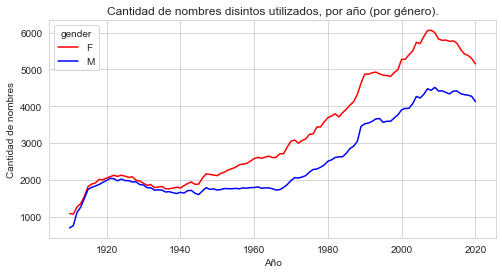

In [41]:
# Grafico Evolucion anual
plt.figure(figsize=(8,4))
sns.set_style('whitegrid')

sns.lineplot(x=annual_names.year, y=annual_names.num_names, hue=annual_names.gender, palette=['r','b'])

plt.title('Cantidad de nombres disintos utilizados, por año (por género).')
plt.xlabel('Año')
plt.ylabel('Cantidad de nombres')

### Conclusiones
De este gráfico se puede observar algo interesante, **la variedad de nombres de hombres y mujeres era prácticamente igual entre los años 1910 y 1940** (fue en aumento en ambos al principio y luego descendió un poco). Luego, **a partir de la década del '40** las curvas de variedad de nombres se despegan notablemente, dando lugar a un **gran aumento de la cantidad de nombres registrados entre las mujeres**, mientras que, por el contrario, el de **hombres se mantuvo prácticamente constante durante casi 30 años** (sería interesante analizar si hubo influencia de la Segunda Guerra Mundial, o bien el comienzo de la industria de medios masivos, como la televisión y el cine, junto con la globalización) . Luego, a partir de la **década del '70, la variedad de nombres entre los hombres comienza a seguir el crecimiento de la curva representativa de las mujeres** hasta la actualidad, manteniendo una **diferencia de un 50%** aproximadamente de mayor variedad entre los **nombres femeninos.**

## Nuevos nombres a lo largo del tiempo

#### ToDo: 
Realizar un gráfico similar al anterior pero que vaya incorporando en la curva los nombres nuevos que aparecen año a año, por ejemplo, 1910 hubo 1000 nombres, luego en 1911 hubo 900, pero fueron todos distintos a los del año anterior, entonces la curva no descenderia sino que aumentaria a 1900 nombres, luego, si en 1912, se usaron todos los mismos nombres, no hubo ninguno nuevo incorporado, la curva se mantendrá constante. Es más que nada para ver con mejor claridad cuando aparecen nombres nuevos, más allá de la variedad del año en particular.

In [20]:
# new_names_query = '''
# SELECT 
# FROM `bigquery-public-data.usa_names.usa_1910_current`
# '''
# new_names_query_job = client.query(new_names_query, job_config=safe_config)
# new_names = new_names_query_job.to_dataframe()
# new_names.head(4)

In [21]:
# new_names.head(20)

## Nombres más utilizados en la historia. Evolución de su uso en el tiempo.

Primero, se obtienen los nombres más utilizados en toda la historia (top 5, hombres y mujeres). Luego, se analiza como varió su uso en el tiempo.

### Top 10 histórico: nombres más utilizados

In [44]:
# Acumulado historico por cada nombre 
# Recordar: se esta diferenciando nombres 
# iguales si fueron asignados a distintos generos
historic_count_names_query = '''
SELECT name, gender, SUM(number) AS historic_number
FROM `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY name, gender
ORDER BY historic_number DESC
'''

historic_count_names_query_job = client.query(historic_count_names_query, job_config=safe_config)
historic_count_names = historic_count_names_query_job.to_dataframe()
historic_count_names.head(10)

,name,gender,historic_number
0,James,M,5023209
1,John,M,4887037
2,Robert,M,4743523
3,Michael,M,4370049
4,William,M,3917442
5,Mary,F,3745809
6,David,M,3615280
7,Richard,M,2543816
8,Joseph,M,2540655
9,Charles,M,2285863


#### Observación
Esta tabla ya nos arroja un dato interesante: **del top 10 de nombres más utilizados 1 sólo es femenino**, lo que, a priori, guarda relación con lo que se concluyó anteriormente, **las mujeres presentan una mucho más amplia variedad de nombres** (por esta razón no repetirían tanto y no aparecen en el histórico de más utilizados)

### Top 5 histórico, masculino y femenino
Se reutliza el código anterior para obtener los "top 5" masculino y femenino, de manera simple.

In [50]:
historic_top_male = historic_count_names[historic_count_names.gender == 'M'].iloc[:5]
historic_top_male

,name,gender,historic_number
0,James,M,5023209
1,John,M,4887037
2,Robert,M,4743523
3,Michael,M,4370049
4,William,M,3917442


In [51]:
historic_top_female = historic_count_names[historic_count_names.gender == 'F'].iloc[:5]
historic_top_female

,name,gender,historic_number
5,Mary,F,3745809
14,Patricia,F,1569464
15,Elizabeth,F,1553025
16,Jennifer,F,1467622
17,Linda,F,1448575


#### Gráfico. Evolución en el tiempo de los nombres Top 5.
Ahora, conociendo los nombres más utilizados en la historia hasta la actualidad, puedo analizar su variación a lo largo del tiempo.

In [22]:
# Uso de los 5 nombres MASCULINOS top historicos a lo largo del tiempo
top_male_evolution_query = '''
SELECT year, name, SUM(number) as year_number
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE name IN (
    SELECT name
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    GROUP BY name, gender
    HAVING gender = 'M'
    ORDER BY SUM(number) DESC
    LIMIT 5
) AND gender = 'M'
GROUP BY year, name
ORDER BY year ASC
'''

top_male_evolution_query_job = client.query(top_male_evolution_query, job_config=safe_config)
top_male_evolution = top_male_evolution_query_job.to_dataframe()
# top_male_evolution.head(10)

In [23]:
# Uso de los 5 nombres FEMENINOS top historicos a lo largo del tiempo
top_female_evolution_query = '''
SELECT year, name, SUM(number) as year_number
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE name IN (
    SELECT name
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    GROUP BY name, gender
    HAVING gender = 'F'
    ORDER BY SUM(number) DESC
    LIMIT 5
) AND gender = 'F'
GROUP BY year, name
ORDER BY year ASC
'''

top_female_evolution_query_job = client.query(top_female_evolution_query, job_config=safe_config)
top_female_evolution = top_female_evolution_query_job.to_dataframe()
# top_female_evolution.head(10)

Text(0, 0.5, 'Veces utilizado')

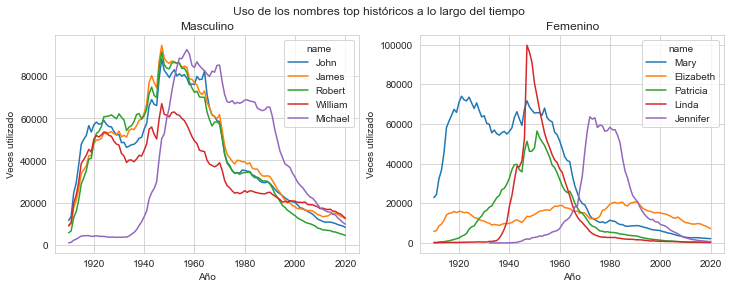

In [12]:
# GRAFICOS, us de los top 5 historicos a lo largo del tiempo
fig, axes = plt.subplots(1,2, sharex=True, figsize=(12,4))

sns.lineplot(ax=axes[0], x=top_male_evolution.year, y=top_male_evolution.year_number, hue=top_male_evolution.name)
sns.lineplot(ax=axes[1], x=top_female_evolution.year, y=top_female_evolution.year_number, hue=top_female_evolution.name)

fig.suptitle('Uso de los nombres top históricos a lo largo del tiempo')
axes[0].set_title('Masculino')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Veces utilizado')
axes[1].set_title('Femenino')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Veces utilizado')

#### Observaciones
1. Del gráfico se pueden extraer conclusiones como la existencia de **tendencias marcadas**. esto es, que en ciertos **períodos de tiempo, determinados nombres son ampliamente utilizados**, para luego, desaparecer casi completamente, o al menos, mermar enormenente su uso. 
2. **Todos los nombres del Top histórico tienen un uso mucho menor en la actualidad** ¿A qué se debe esto? Averiguar los nombres tendencia actuales y en qué cantidad se usan ¿son mucho más usados? o al haber tanta variedad en la actualidad cada nombre es mucho menos usado.

Una cuestión que parece interesante desarrollar es el caso de las tendencias en el uso de ciertos nombres y la razón de las mismas. Se observa, por ejemplo, el caso del nombre Linda, el cual presetan una fuerte preponderancia, en la decada de 1940, para luego, desaparecer casi por completo. Para intentar comprender las razones que llevaron a que su uso sea tan marcado en dichos años, se realiza una simple búsqueda en *Google: Linda + 1940* y se observa que hubo una actriz de gran popularidad en esa época, lo cual muy posiblemente haya dado lugar al gran uso de su nombre.

<img src="images/linda-1940.png" alt="Linda Darnell, tendencia 1940" width="600"/>

### Top 5 nombres actualidad (2020), masculino y femenino.
Analizo el top 5 de nombres de la actualidad, a fin de observar cómo es su uso respecto de los que integran el "Top 5 histórico".

In [19]:
# Usos de cada nombre en 2020, ordenado de mayor a menor
names_count_2020_query = '''
SELECT name, gender, SUM(number) AS number_2020
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE year = 2020
GROUP BY name, gender
ORDER BY number_2020 DESC
'''

names_count_2020_query_job = client.query(names_count_2020_query, job_config=safe_config)
names_count_2020 = names_count_2020_query_job.to_dataframe()
# names_count_2020.head(3)

# Selecciono los top 5 de cada genero
top_male_2020 = names_count_2020[names_count_2020.gender == 'M'].iloc[:5]
top_female_2020 = names_count_2020[names_count_2020.gender == 'F'].iloc[:5]

In [20]:
top_male_2020

,name,gender,number_2020
0,Liam,M,19659
1,Noah,M,18252
4,Oliver,M,14147
6,Elijah,M,13034
10,William,M,12541


In [21]:
top_female_2020

,name,gender,number_2020
2,Olivia,F,17535
3,Emma,F,15581
5,Ava,F,13084
7,Charlotte,F,13003
8,Sophia,F,12976


Ahora, comparo el uso de los nombres top actuales, con el de los top historicos:

In [24]:
# Uso de los 5 nombres MASCULINOS top 2020 a lo largo del tiempo
top_2020_male_evolution_query = '''
SELECT year, name, SUM(number) as year_number
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE name IN (
    SELECT name
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE year = 2020 AND gender = 'M'
    GROUP BY name
    ORDER BY SUM(number) DESC
    LIMIT 5
) AND gender = 'M'
GROUP BY year, name
ORDER BY year ASC
'''

top_2020_male_evolution_query_job = client.query(top_2020_male_evolution_query, job_config=safe_config)
top_2020_male_evolution = top_2020_male_evolution_query_job.to_dataframe()

In [28]:
# Uso de los 5 nombres FEMENINOS top 2020 a lo largo del tiempo
top_2020_female_evolution_query = '''
SELECT year, name, SUM(number) as year_number
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE name IN (
    SELECT name
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE year = 2020 AND gender = 'F'
    GROUP BY name
    ORDER BY SUM(number) DESC
    LIMIT 5
) AND gender = 'F'
GROUP BY year, name
ORDER BY year ASC
'''

top_2020_female_evolution_query_job = client.query(top_2020_female_evolution_query, job_config=safe_config)
top_2020_female_evolution = top_2020_female_evolution_query_job.to_dataframe()

Text(0.5, 1.0, 'Femenino - Top 5 2020')

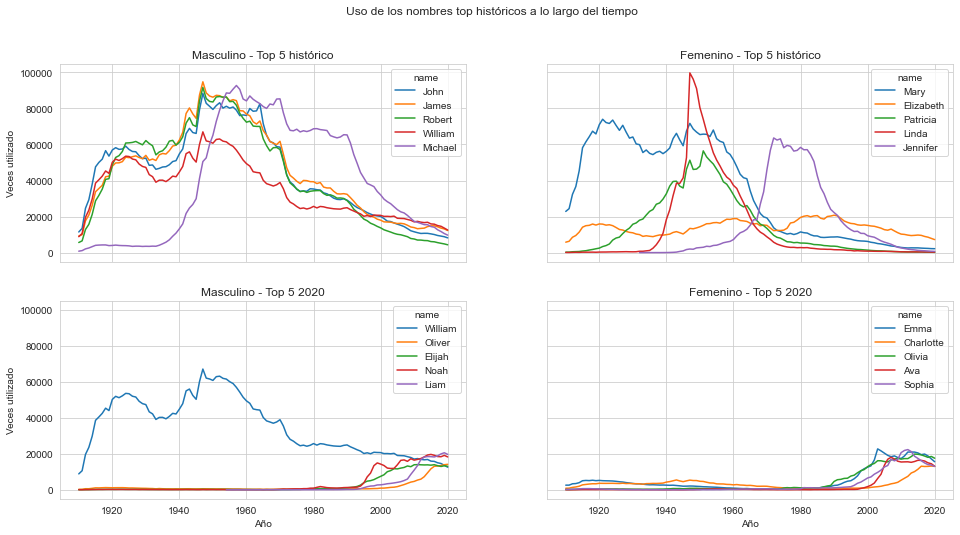

In [62]:
# GRAFICOS, comparacion uso de los top 5 actuales e historicos a lo largo del tiempo
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(16,8))

sns.lineplot(ax=axes[0,0], x=top_male_evolution.year, y=top_male_evolution.year_number, hue=top_male_evolution.name)
sns.lineplot(ax=axes[1,0], x=top_2020_male_evolution.year, y=top_2020_male_evolution.year_number, hue=top_2020_male_evolution.name)

sns.lineplot(ax=axes[0,1], x=top_female_evolution.year, y=top_female_evolution.year_number, hue=top_female_evolution.name)
sns.lineplot(ax=axes[1,1], x=top_2020_female_evolution.year, y=top_2020_female_evolution.year_number, hue=top_2020_female_evolution.name)

fig.suptitle('Uso de los nombres top históricos a lo largo del tiempo')
plt.setp(axes[-1, :], xlabel='Año')
plt.setp(axes[:, 0], ylabel='Veces utilizado')
axes[0,0].set_title('Masculino - Top 5 histórico')
axes[0,1].set_title('Femenino - Top 5 histórico')
axes[1,0].set_title('Masculino - Top 5 2020')
axes[1,1].set_title('Femenino - Top 5 2020')

### Conclusiones
Del último gráfico se desprende la respuesta a la pregunta surgida en las conclusiones del item anterior, ya que aquí se observa que el uso de los nombres mas recurrentes de la actualidad presenta cantidades similares (o al menos no enormemente superiores) a las de los "top históricos" esto se debería a que, en la actualidad al haber una mayor variedad de nombres, cada uno es menos repetido en general.

### Mapa de calor por Estado de los nombres top (última década)

De los 5 nombres femeninos y masculinos más utlilzados en el 2010-2020, analizo su uso por estado, para ver si hay alguna influencia geográfica fuerte.

In [3]:
# top_names_decade -> 5 masc y 5 femeninos mas utilizados de la decada
top_names_decade_query = '''
SELECT name, 
       gender,
       SUM(number) AS decade_number, 
       RANK() OVER (
           PARTITION BY gender
           ORDER BY SUM(number) DESC
       ) AS decade_ranking
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE year >= 2010 AND year <= 2020
GROUP BY name, gender
ORDER BY decade_ranking ASC
LIMIT 10
'''

top_names_decade_query_job = client.query(top_names_decade_query, job_config=safe_config)
top_names_decade = top_names_decade_query_job.to_dataframe()
top_names_decade

,name,gender,decade_number,decade_ranking
0,Emma,F,210336,1
1,Noah,M,201245,1
2,Liam,M,193376,2
3,Olivia,F,201826,2
4,William,M,172238,3
5,Sophia,F,193872,3
6,Isabella,F,182331,4
7,Jacob,M,172136,4
8,Ava,F,168690,5
9,Mason,M,167681,5


In [6]:
# Luego, sobre estos, consulto su uso en cada Estado
top_names_decade_states_query = '''
WITH top_names_decade AS (
    SELECT name, 
           gender,
           SUM(number) AS decade_number, 
           RANK() OVER (
               PARTITION BY gender
               ORDER BY SUM(number) DESC
           ) AS decade_ranking
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE year >= 2010 AND year <= 2020
    GROUP BY name, gender
    ORDER BY decade_ranking ASC
    LIMIT 10
)

SELECT n.name, n.gender, n.state, SUM(n.number) AS state_number    
FROM `bigquery-public-data.usa_names.usa_1910_current` AS n
RIGHT JOIN top_names_decade AS tnd
    ON tnd.name = n.name AND tnd.gender = n.gender
WHERE year >= 2010 AND year <= 2020
GROUP BY name, gender, state
ORDER BY state_number DESC
'''

top_names_decade_states_query_job = client.query(top_names_decade_states_query, job_config=safe_config)
top_names_decade_states = top_names_decade_states_query_job.to_dataframe()
top_names_decade_states.head(3)

,name,gender,state,state_number
0,Sophia,F,CA,31608
1,Isabella,F,CA,28255
2,Noah,M,CA,28049


#### Gráfico. Uso de los nombres Top de la década (2010-2020) a lo largo de USA
**Nota:** Para simplificar la tarea, ya que en el top de nombres no hay ninguno compartido entre géneros, puedo discriminar directamente por *name* para graficar sin ser necesario utilizar la combinación *name + gender*.

<AxesSubplot:xlabel='name', ylabel='state'>

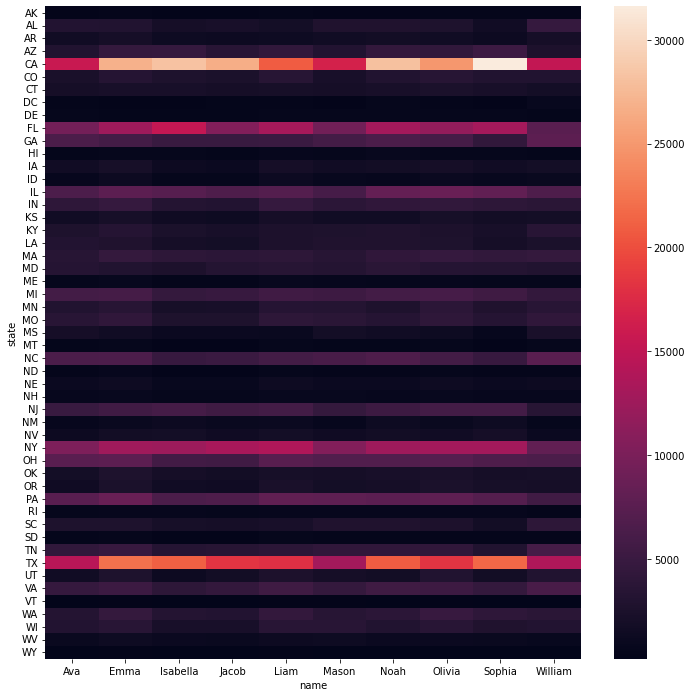

In [5]:
# primero debo pivotear la tabla para poder graficar
top_names_decade_states_wide = top_names_decade_states.pivot('state', 'name', 'state_number')

plt.figure(figsize=(12,12))
sns.heatmap(data=top_names_decade_states_wide, annot=False)

#### Conclusiones
Del gráfico se puede observar una correlación directa entre los Estados donde más se utilizan los mencionados nombres y los Estados donde más cantidad de nacimientos se registran, por tanto, a priori, no habría una marcada zonificación para el uso de estos nombres (se usan de manera similar a lo largo de todo el territorio).

Como comentario, podríamos mencionar el caso de "*Sophia*", el cual se encuentra fuertemente utilizado en California y notablemente menos en el resto de los Estados.

#### Gráfico. Uso de los nombres Top de la década (2010-2020) a lo largo de USA (Geográfico)
Finalizando este análisis de los nombres utilizados en Estados Unidos a lo largo del último siglo y de su extensión geográfica, a continuación, se puede observar un gráfico dinámico interactivo, donde se puede seleccionar cada uno de los nombres más recurrentes de la última década y visualizar su uso a lo largo de todo el territorio del país.

**ToDo:** No pude generar el mapa para graficar, porque no logré instalar geopandas.

In [8]:
# Uso de Widgets para GUI: Selector, Dropdown
import ipywidgets as widgets

top_names_decade_sorted = list(top_names_decade.name.values)
top_names_decade_sorted.sort()

dropdown_name = widgets.Dropdown(options=top_names_decade_sorted)

#captura el valor de la salida -> Lo que se dispara al seleccionar un item del dropdwn
output_plot = widgets.Output()

# handler al seleccionar item del dropdwn
def dropdown_name_eventhandler(change):
    output_plot.clear_output()
    with output_plot:
        plt.figure(figsize=(12,6))
        sns.barplot(x=top_names_decade_states[top_names_decade_states.name == change.new].state, y=top_names_decade_states[top_names_decade_states.name == change.new].state_number)
        plt.show()

# queda a la espera de un evento en el dropdown        
dropdown_name.observe(dropdown_name_eventhandler, names='value')
display(dropdown_name)

Dropdown(options=('Ava', 'Emma', 'Isabella', 'Jacob', 'Liam', 'Mason', 'Noah', 'Olivia', 'Sophia', 'William'),…

In [9]:
# muestro la salida -> Lo que se dispara al cambiar el dropdown
display(output_plot)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 864x432 with 1 Axes>', 'i…